In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

df = pd.read_csv('../data/model_input_with_interactions.csv')  

###  New Interaction Features

In [16]:
df['diagnosis_x_severity'] = df['diagnosis_encoded'] * df['severity_encoded']
df['procedure_x_severity'] = df['procedure_encoded'] * df['severity_encoded']
df['diagnosis_x_procedure'] = df['diagnosis_encoded'] * df['procedure_encoded']
df['county_x_los'] = df['county_encoded'] * df['los']

### Feature Columns

In [17]:
feature_cols = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded',
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded',
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county',
    'diagnosis_x_severity', 'procedure_x_severity', 
    'diagnosis_x_procedure', 'county_x_los'
]

In [18]:
# Train-test split
X = df[feature_cols]
y = np.log1p(df['total_charges'])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Train model
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2544
[LightGBM] [Info] Number of data points in the train set: 1873243, number of used features: 17
[LightGBM] [Info] Start training from score 10.142437


LGBMRegressor(learning_rate=0.05, n_estimators=1000)

### Evaluate Performance 

In [20]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

mae = mean_absolute_error(y_actual, y_pred)
print(f"New LightGBM MAE with interaction features: ${mae:,.2f}")

New LightGBM MAE with interaction features: $13,057.92


## Residual Group Analysis

In [21]:
labeled = df.copy()
labeled['model_prediction'] = model.predict(df[feature_cols])
labeled['residual'] = labeled['total_charges'] - labeled['model_prediction']

### Top Diagnoses

In [29]:
# Load diagnosis mapping
diag_map = pd.read_csv('../data/diagnosis_mapping.csv')

# Merge readable diagnosis
labeled = labeled.merge(diag_map, on='diagnosis_encoded', how='left')

In [ ]:
# Grouping and sorting
res_by_diag = (
    labeled.groupby('ccs_diagnosis_description')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')
    .sort_values(by='avg_residual', ascending=False)
)

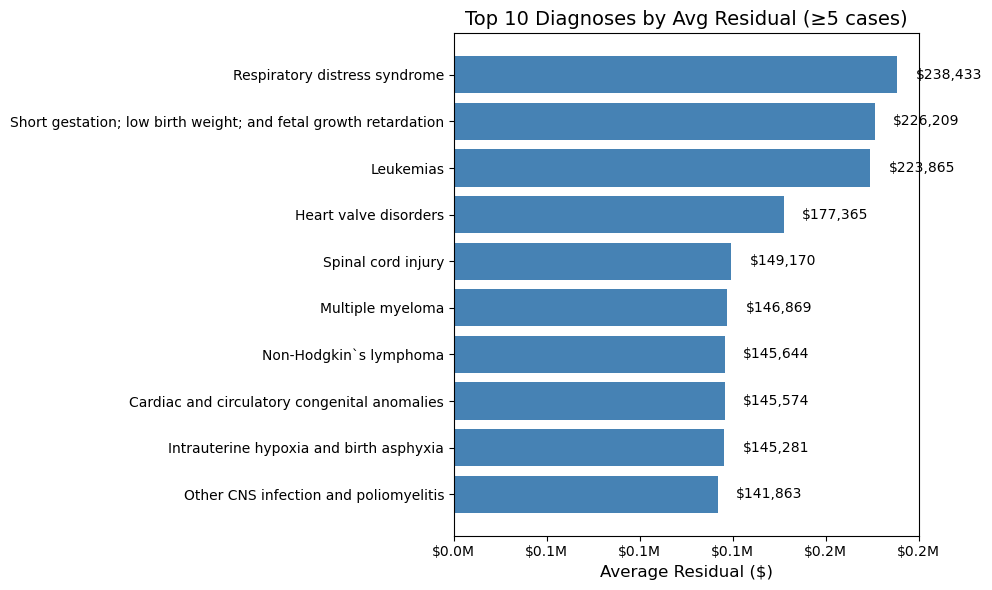

In [ ]:
# Plotting
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Filter for top 10 diagnoses
top_10 = res_by_diag.head(10).sort_values('avg_residual')


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_10.index, top_10['avg_residual'], color='steelblue')

# Format x-axis in $millions
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Add labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 10000, bar.get_y() + bar.get_height()/2, f'${width:,.0f}', va='center')

# Titles and labels
ax.set_title('Top 10 Diagnoses by Avg Residual (≥5 cases)', fontsize=14)
ax.set_xlabel('Average Residual ($)', fontsize=12)
plt.tight_layout()
plt.show()